In [26]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
from pandas_datareader import data
from stockmarket.stylizedfacts import *
from math import isclose

In [2]:
import powerlaw

# Simulation

In [42]:
from stockmarket import baselinemodel

In [43]:
#%prun baselinemodel.stockMarketSimulation(seed=0, simulation_time=10, amount_momentum=40, amount_mean_reversion=40, amount_firms=1,initial_money=(100, 200),initial_bid_ask=(1,1), initial_memory=(3,7),initial_ma_short=(2,3), initial_ma_long=(6,7),initial_profit=(200,200),initial_book_value=(10000, 10000),initial_stock_amount=400,order_expiration_time=120,init_propensity_to_switch=1.1,init_price_to_earnings_window=(6, 12),firm_profit_mu=0.058,firm_profit_delta=0.00396825396,firm_profit_sigma=0.125,printProgress=False)

In [55]:
SIMTIME = 100

In [54]:
agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                         simulation_time=SIMTIME,
                                                                         init_backward_simulated_time=200,
                                                                         number_of_agents=1000,
                                                                         share_chartists=0.0,
                                                                         share_mean_reversion=0.5,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(28000,28000),
                                                                         initial_profit=(1000, 1000),
                                                                         discount_rate=0.11,
                                                                         init_price_to_earnings_window=((4, 7), (10, 14)),
                                                                         order_expiration_time=200,
                                                                         agent_order_price_variability=(1,1),
                                                                         agent_order_variability=1.5,
                                                                         agent_ma_short=(20, 40),
                                                                         agent_ma_long=(120, 150),
                                                                         agents_hold_thresholds=(0.9995, 1.0005),
                                                                         agent_volume_risk_aversion=0.1,
                                                                         agent_propensity_to_switch=1.1,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=20,
                                                                         printProgress=False,
                                                                         )

# Quick results

## Firm profits

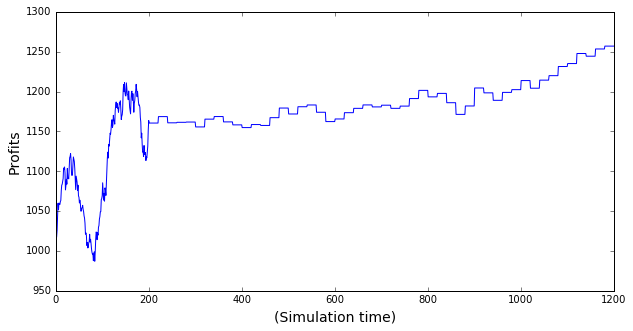

In [56]:
profits = firms[0].profit_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(profits)), profits)

ax1.set_ylabel('Profits', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

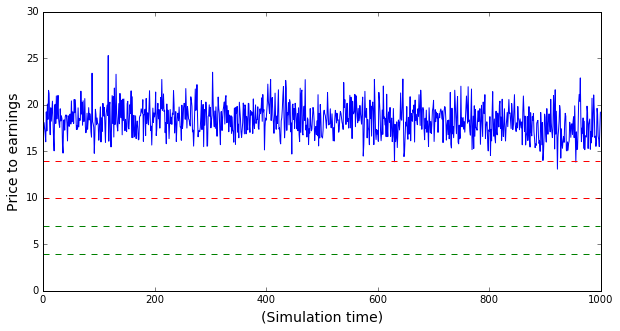

In [57]:
price_to_earnings = stocks[0].price_to_earnings_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(price_to_earnings)), price_to_earnings)
ax1.plot(range(len(price_to_earnings)), [4 for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [7 for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [10 for x in range(len(price_to_earnings))], 'r--')
ax1.plot(range(len(price_to_earnings)), [14 for x in range(len(price_to_earnings))], 'r--')
#ax1.plot(range(len(price_to_earnings)), )

#ax1.set_ylim(0, 16)

ax1.set_ylabel('Price to earnings', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

In [58]:
np.mean(stocks[0].price_to_earnings_history)

18.347806561083182

# Buy and sell orders

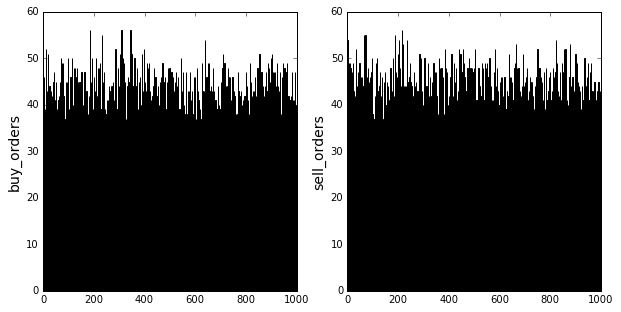

In [11]:
buy_orders = order_books[0].buy_orders_history
sell_orders = order_books[0].sell_orders_history
#sell_orders

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(range(len(buy_orders)), buy_orders)
ax2.bar(range(len(sell_orders)), sell_orders)


ax1.set_ylabel('buy_orders', fontsize='14')
ax2.set_ylabel('sell_orders', fontsize='14')

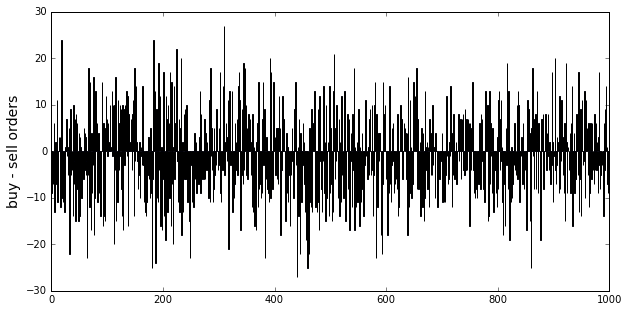

In [12]:
buy_minus_sell_orders = np.array(buy_orders) - np.array(sell_orders)

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(buy_minus_sell_orders)), buy_minus_sell_orders)


ax1.set_ylabel('buy - sell orders', fontsize='14')

# Market Prices and Volume

In [13]:
prices = order_books[0].transaction_prices_history
averageprices = []
for day in prices:
    averageprices.append(np.mean(day))

In [14]:
closingprices = []
for day in prices:
    closingprices.append(day[-1])

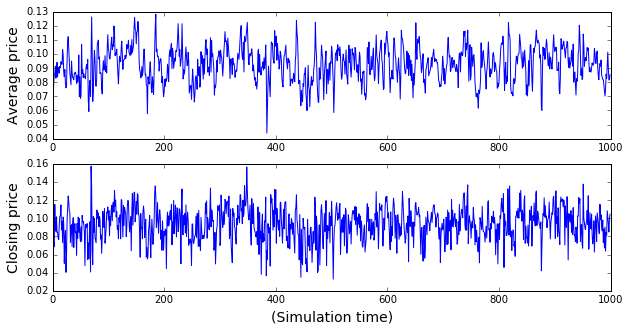

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(range(len(averageprices)), averageprices)
ax2.plot(range(len(closingprices)), closingprices)

ax1.set_ylabel('Average price', fontsize='14')
ax2.set_ylabel('Closing price', fontsize='14')
ax2.set_xlabel('(Simulation time)', fontsize='14')

In [16]:
volume = order_books[0].transaction_volumes_history
totalvolume = []
for day in volume:
    totalvolume.append(sum(day))

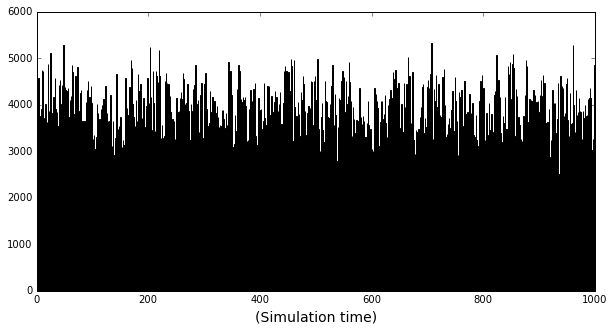

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(totalvolume)), totalvolume)

ax1.set_xlabel('(Simulation time)', fontsize='14')

## Intraday prices

In [18]:
all_transaction_prices = order_books[0].transaction_prices_history

In [19]:
all_transaction_prices = list(itertools.chain.from_iterable(all_transaction_prices))

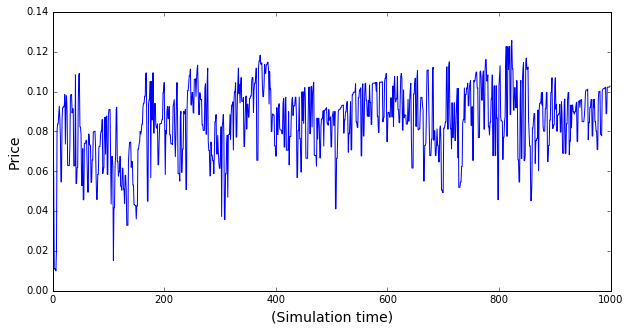

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

zoomed_prices = all_transaction_prices[:1000]

ax1.plot(range(len(zoomed_prices)), zoomed_prices)

ax1.set_ylabel('Price', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Strategy switching

In [21]:
def percentageMomentum(period, agents):
    momentum = 0
    queryString = 'momentum'
    for agent in agents:
        function = str(agent.function_history[period])
        if queryString in function:
            momentum += 1
    return momentum / (len(agents))

In [22]:
percFund = []
for period in range(SIMTIME):
    percFund.append(percentageMomentum(period, agents))

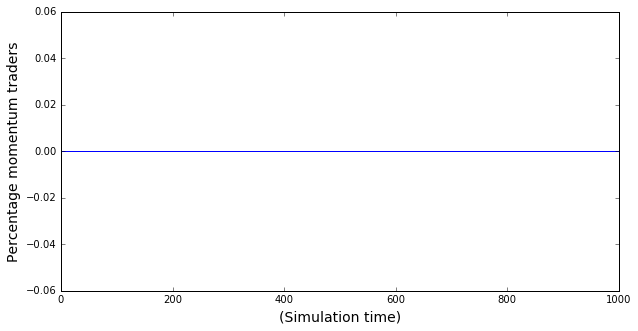

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(percFund)), percFund)

ax1.set_ylabel('Percentage momentum traders', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

## Actual s&p 500 data

In [24]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']
spy_returns = spy.pct_change()[1:]

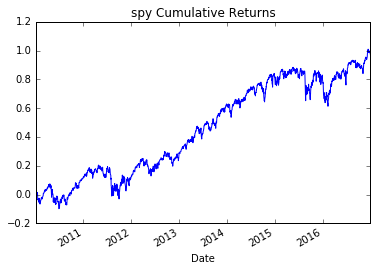

In [25]:
((1 + spy_returns).cumprod() - 1).plot(title='spy Cumulative Returns')

# Stylized facts

Most of the text comes from: Rama Cont (2001) Journal of Quantitative Finance

How to replicate these? 
* centrifugal forces (for volatility clusering and fat tails) = mean reversion, trend following & fundamental component)
* very low autocorrelation? ... stochasticity? 
* large positive autocorrelation in volume? 

In [27]:
# test 1
zero_autocorrelation(calculate_returns(order_books[0].transaction_prices_history), 25)

True

In [28]:
zero_autocorrelation(spy_returns, 25)

True

In [29]:
# test 2
fat_tails(calculate_returns(order_books[0].transaction_prices_history))

Calculating best minimal value for power law fit


2.77354362724


True

In [30]:
fat_tails(spy_returns)

4.10038523727


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


True

In [31]:
# test 3
clustered_volatility(calculate_returns(order_books[0].transaction_prices_history), 25)

0.0193187179959


False

In [32]:
clustered_volatility(spy_returns, 25)

0.154848633766


True

In [33]:
# test 4 NOTE I think you should not do this on the returns TODO
long_memory(calculate_close(order_books[0].transaction_prices_history), hurst, 2, 20)

h =  -0.00153493601815


True

In [34]:
long_memory(spy, hurst, 2, 20)

h =  0.425635227107


True

## 1 Returns

In [35]:
returns = pd.Series(averageprices).diff()
squared_returns = np.square(returns)

In [36]:
stats = [returns.std(), returns.min(), returns.max(), returns.skew(), returns.kurtosis()]
sp500 = [0.008, -0.082, 0.051, -0.187, 8.512]
index = ['standard_deviation', 'minimum', 'maximum', 'skewness', 'kurtosis']

In [37]:
pd.DataFrame({'Simulation':stats, 'S&P500': sp500}, index=index)

,S&P500,Simulation
standard_deviation,0.008,0.009815
minimum,-0.082,-0.043160
maximum,0.051,0.036726
skewness,-0.187,0.049568
kurtosis,8.512,1.101500


### 1.1 Very low autocorrelation

(linear) autocorrelations of asset returns are often insignificant, except for very
small intraday time scales ( 20 minutes) for which microstructure effects come into play.

add a bit of stochasticity? 

In some models such as Ghonghadze & Lux 2016. Changes in the fundamental value are driven by a brownian motion, which in turn drives the low autocorrelations. 

In [35]:
autocorr_returns = [returns.autocorr(lag=lag) for lag in range(25)]
autocorr_squared_returns = [squared_returns.autocorr(lag=lag) for lag in range(25)]

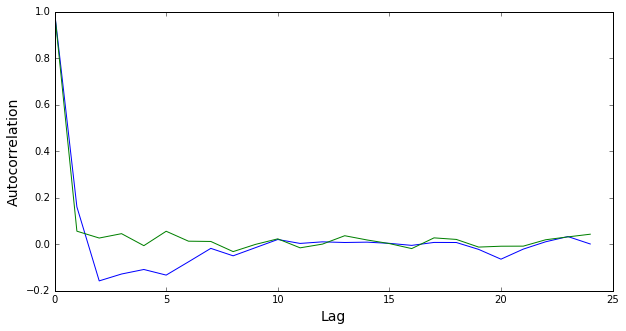

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))


ax1.plot(range(len(autocorr_returns)), autocorr_returns)
ax1.plot(range(len(autocorr_squared_returns)), autocorr_squared_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 1.2 Fait tails

fat tails of the unconditional distribution
of returns

**How to measure: calculate the powerlaw exponent (alpha)**

In [37]:
h = sorted(list(returns[1:]))
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.hist(h, normed=True)

AttributeError: 'list' object has no attribute 'norm'

### Power law exponent / alpha

the tails of the distribution at the shortest time scales were reported to be well-approximated by a powerlaw with exponent α ≈ 3. This tail might be a consequence of powerlaw tails in both the distribution of market order sizes and the instantaneous mid-price logarithmic return impact function. in emerging markets. Dro˙zd˙z et al. (2007) reported that the tails were less heavy (i.e. α > 3).  Longer time scales should lead to a closer and closer approximation by the normal distribution

In [38]:
results = powerlaw.Fit(returns[1:])
print(results.power_law.alpha)

Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1138: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1157: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


2.79419911075


C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


### 1.3 Clustered volatility

Volatility clustering characterizing their conditional distribution. Probably tied to over-optimism / over pessimism. 

### 1.3.1 Autocorrelation absolute returns 

In [40]:
# one measure for persistent volatility is plotting the autocorrelation of the absolute retunrs
absolute_returns = returns.abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]
absolute_spy_returns = spy_returns.abs()
autocorr_spy_abs_returns = [absolute_spy_returns.autocorr(lag=lag) for lag in range(25)]

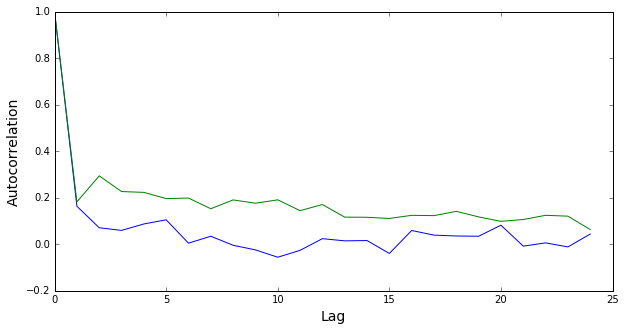

In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns)
ax1.plot(range(len(autocorr_spy_abs_returns)), autocorr_spy_abs_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

## 2 Volume
### 2.1 Large positive autocorrelation

In [45]:
vol = pd.Series(totalvolume)

In [46]:
autocorr_volume = [vol.autocorr(lag=lag) for lag in range(25)]

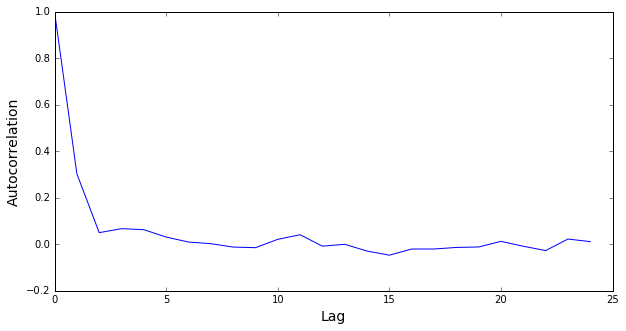

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_volume)), autocorr_volume)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 2.2 Correlation between high price volatility and large volumes